# Change points detection algorithm
- From keypoint MoSeq
- Basseville, M., and Nikiforov, I.V. (1993). Detection of abrupt changes (Prentice-Hall Publishing).

In [80]:
""" 
IMPORTS
"""
import os
import autograd.numpy as np
import pickle
import seaborn as sns
from collections import defaultdict
import pandas as pd
import matplotlib.pyplot as plt

# --Machine learning and statistics
from sklearn.preprocessing import StandardScaler, Normalizer
from scipy.ndimage import gaussian_filter1d
from scipy.signal import argrelmax, argrelextrema
from scipy.stats import zscore
from scipy.stats import ttest_1samp

from one.api import ONE
one = ONE()


## Parameters

In [2]:
bin_size = 0.1

data_path_v1 =  '/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Design matrix/' + 'v1/' + str(bin_size) + '/'
data_path_v2 =  '/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Design matrix/' + 'v2_3Nov2023/' + str(bin_size) + '/'
data_path_v2 =  '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/DATA/Sub-trial/Design matrix/' + 'v2_3Nov2023/' + str(bin_size) + '/'

data_path = data_path_v2

os.chdir(data_path)
design_matrices = os.listdir(data_path)

if data_path == data_path_v1:
       var_names = ['avg_wheel_vel', 'pupil_diameter',
              'whisker_me', 'nose_speed_X', 'nose_speed_Y', 
              'l_paw_speed_X', 'l_paw_speed_Y', 'pupil_speed_X',
              'pupil_speed_Y', 'Gaussian_licks']
elif data_path == data_path_v2:
       var_names = ['avg_wheel_vel', 'pupil_diameter',
              'whisker_me', 'nose_speed', 'l_paw_speed', 'left_X', 'left_Y',
              'pupil_speed', 'pupil_X', 'pupil_Y', 'Lick count']

# Plotting params
multiplier = 1/bin_size

event_type_list = ['goCueTrigger_times']  # , 'feedback_times', 'firstMovement_times'
event_type_name = ['Go cue']  # , 'Feedback time', 'First movement onset'

## Preprocess list of design matrices

In [3]:
# Save data of all sessions for latter
matrix_all = defaultdict(list)
matrix_all_unnorm = defaultdict(list)
session_all = defaultdict(list)

for m, mat in enumerate(design_matrices[0:1]):
    
    # Trials data
    session = design_matrices[m][14:-4]
    
    #session = '2e6e179c-fccc-4e8f-9448-ce5b6858a183'
    #mat = 'design_matrix_2e6e179c-fccc-4e8f-9448-ce5b6858a183_0.1new_version'
    
    session_trials = one.load_object(session, obj='trials', namespace='ibl')
    session_trials = session_trials.to_df()
    session_end = list(session_trials['stimOff_times'][-1:])[0]  # TODO: this might not work if stimOff times are missing
    session_start = list(session_trials['stimOn_times'])[0]
    
    big_design_matrix = pickle.load(open(mat, "rb"))
    
    design_matrix = big_design_matrix.groupby('Bin')[var_names].mean()  # 
    design_matrix = design_matrix.reset_index(level = [0])  # , 'Onset times'
    design_matrix = design_matrix.dropna()
    
    # Trim design matrix to be as long as the session (otherwise it will include task-unrelated behavior)
    design_matrix = design_matrix.loc[(design_matrix['Bin'] < session_end * 10) & (design_matrix['Bin'] > session_start * 10)]
    training_set = np.array(design_matrix[var_names]).copy() 
    
    if len(training_set) > 0:
      # Standardization using StandardScaler
      scaler = StandardScaler()
      standardized = scaler.fit_transform(training_set)
      # # Normalize between 0 and 1
      normalizer = Normalizer()  # norm='max'
      normalized = normalizer.fit_transform(standardized)
      
    # Save results
    matrix_all[mat].append(normalized)
    # matrix_all[mat].append(normalized)
    session_all[mat].append(session_trials)    
    matrix_all_unnorm[mat].append(design_matrix) 

In [4]:
use_data = design_matrix[var_names].copy()  # To keep the column names
use_data[var_names] = matrix_all[mat][0]

use_data['Lick count'] = gaussian_filter1d(use_data['Lick count'], sigma=1)  # TODO: how to decide on sigma here???
#plt.hist(use_data['Lick count'])

### Parameters
Need to do grid-search on this

In [5]:
k = 4  # bin lag for derivative calculation
h = 01.5  # thresold??
sigma = 0.43  # for Gaussian filter

k = 2
h = 0.5
sigma = 0.7

shuffle_iters = 1000

### Derivative

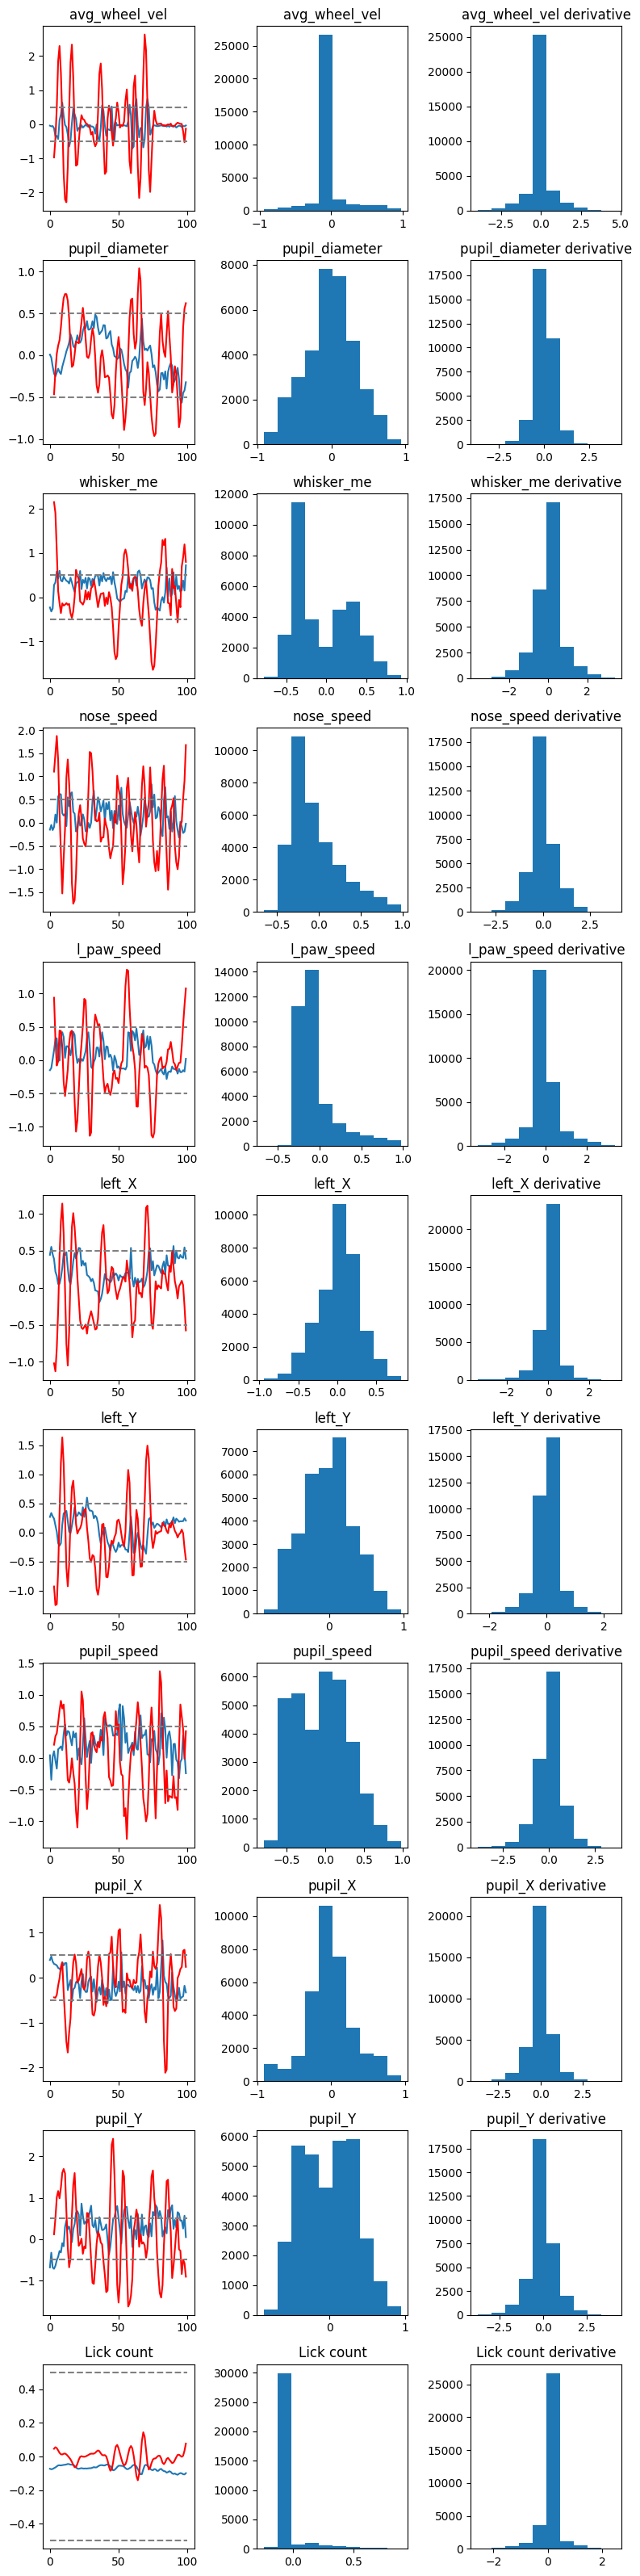

In [6]:
derivative = use_data.copy()
features = use_data.keys()

min = 0
max = 100

fig, ax = plt.subplots(nrows=len(features) , ncols=3, sharex=False, sharey=False, figsize=[8, 32])

for i, feat in enumerate(features):
    derivative[feat] = derivative[feat].shift(-3) + derivative[feat].shift(-2) + derivative[feat].shift(-1) - derivative[feat].shift(1) - derivative[feat].shift(2) - derivative[feat].shift(3) 
    
    ax[i, 0].plot(use_data[feat][min:max])
    ax[i, 0].plot(derivative[feat][min:max], color='red')
    ax[i, 0].hlines(h, min, max, linestyles='--', color='Gray')
    ax[i, 0].hlines(-h, min, max, linestyles='--', color='Gray')
    ax[i, 2].hist(derivative[feat])
    ax[i, 1].hist(use_data[feat])
    ax[i, 0].set_title(feat)
    ax[i, 2].set_title(str(feat + ' derivative'))
    ax[i, 1].set_title(feat)

plt.tight_layout()


### Thresholding

In [7]:
df_zscore = derivative[np.array(features)]
thresholded = df_zscore.apply(zscore, nan_policy='omit')

for i, feat in enumerate(features):
    thresholded.loc[(thresholded[feat] >= -h) & (thresholded[feat] <= h), feat] = 0
    thresholded.loc[thresholded[feat] > h, feat] = 1
    thresholded.loc[thresholded[feat] < -h, feat] = 1

summed_threshold = np.sum(thresholded, axis=1)

### Gaussian filter

In [8]:
# Apply Gaussian filter
smoothed_signal = gaussian_filter1d(summed_threshold, sigma=sigma)

(0.0, 100.0)

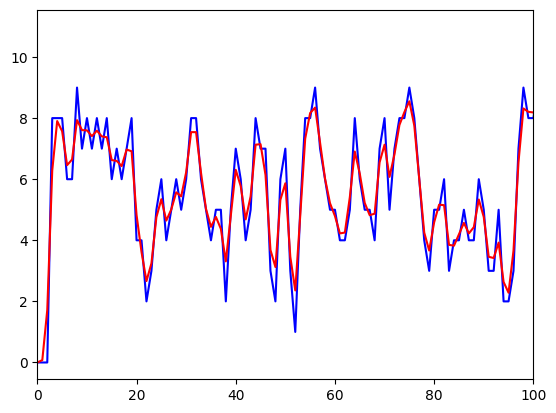

In [9]:
plt.plot(summed_threshold, color='blue')
plt.plot(smoothed_signal, color='red')
plt.xlim([0, 100])

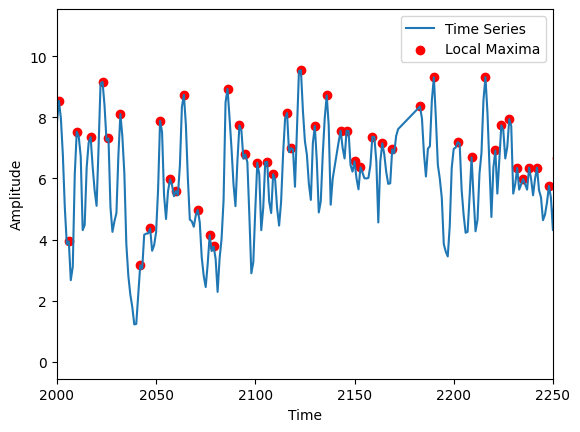

In [10]:
local_maxima = argrelextrema(smoothed_signal, np.greater)

time = design_matrix['Bin']
# Plot the time series and local maxima
plt.plot(time, smoothed_signal, label='Time Series')
plt.scatter(time[local_maxima[0]], smoothed_signal[local_maxima[0]], color='red', label='Local Maxima')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.xlim([2000, 2250])
plt.show()

## Functions

In [86]:
def changepoints(use_data, h, sigma):
        
    features = use_data.keys()

    # Derivative
    derivative = use_data.copy()
    for i, feat in enumerate(features):
        derivative[feat] = derivative[feat].shift(-3) + derivative[feat].shift(-2) + derivative[feat].shift(-1) - derivative[feat].shift(1) - derivative[feat].shift(2) - derivative[feat].shift(3) 

    # z-score
    df_zscore = derivative[np.array(features)]
    thresholded = df_zscore.apply(zscore, nan_policy='omit')

    # Threshold
    for i, feat in enumerate(features):
        # thresholded[pc] = thresholded[pc] * np.nan
        thresholded.loc[(thresholded[feat] >= -h) & (thresholded[feat] <= h), feat] = 0
        thresholded.loc[thresholded[feat] > h, feat] = 1
        thresholded.loc[thresholded[feat] < -h, feat] = 1

    # Sum
    summed_threshold = np.sum(thresholded, axis=1)

    # Smooth
    smoothed_signal = gaussian_filter1d(summed_threshold, sigma=sigma)
        
    return smoothed_signal


def cyclic_permutation(use_data):
    
    permuted_data = use_data.copy()
    
    features = use_data.keys()
    for f, feat in enumerate(features):
        # Generate a random interval for cyclic permutation
        random_interval = np.random.randint(1, np.shape(use_data)[0])

        # Cyclically permute the time series
        permuted_data[feat] = np.roll(use_data[feat], random_interval)

    return permuted_data


def shuffled(use_data, shuffle_iters, h, sigma):
    
    changepoints_shuffled = np.zeros((shuffle_iters, np.shape(use_data)[0]))
    
    features = use_data.keys()

    for s in range(shuffle_iters):
        
        # Randomly permute each keypoint timeseries
        permuted_data = cyclic_permutation(use_data)

        # Derivative
        derivative = permuted_data.copy()
        for i, feat in enumerate(features):
            derivative[feat] = derivative[feat].shift(-3) + derivative[feat].shift(-2) + derivative[feat].shift(-1) - derivative[feat].shift(1) - derivative[feat].shift(2) - derivative[feat].shift(3) 

        # z-score 
        df_zscore = derivative[np.array(features)]
        thresholded = df_zscore.apply(zscore, nan_policy='omit')

        # Threshold
        for i, feat in enumerate(features):
            # thresholded[pc] = thresholded[pc] * np.nan
            thresholded.loc[(thresholded[feat] >= -h) & (thresholded[feat] <= h), feat] = 0
            thresholded.loc[thresholded[feat] > h, feat] = 1
            thresholded.loc[thresholded[feat] < -h, feat] = 1

        # Sum
        summed_threshold = np.sum(thresholded, axis=1)

        # Smooth
        smoothed_signal = gaussian_filter1d(summed_threshold, sigma=sigma)
        
        # Save
        changepoints_shuffled[s, :] = smoothed_signal
        
    return changepoints_shuffled


def peaks(use_data, h, sigma, shuffle_iters):
    
    data_changepoints = changepoints(use_data, h, sigma)
    shuffle_changepoints = shuffled(use_data, shuffle_iters, h, sigma)

    timesteps = np.shape(use_data)[0]
    change_score = np.zeros((timesteps))
    p_values = np.zeros((timesteps))

    # 1-sample t-test to compare data changepoints to shuffled distribution
    for t in range(timesteps):
        # Check if data changepoints is higher than shuffle
        if data_changepoints[t] > np.mean(shuffle_changepoints[:, t]):

            # Perform one-sample t-test
            _, p_value = ttest_1samp(shuffle_changepoints[:, t], data_changepoints[t])
            
            # To avoid numerical error
            if p_value == 0:
                p_value = 0.00000001
            
            p_values[t] = p_value
            change_score[t] = -np.log(p_value)
        
        else:
            p_values[t] = 1  # set p_value to an arbitrarily high value
            change_score[t] = -np.log(1)

    # Detect local maxima
    local_maxima = argrelmax(change_score)  # , np.greater
    significant = np.where(p_values< 0.01)
    # Find intersection of significant peaks
    intersect = np.intersect1d(significant, local_maxima)

    return change_score, data_changepoints, shuffle_changepoints, intersect

In [ ]:
change_score, data_changepoints, shuffle_changepoints, intersect = peaks(use_data, h, sigma, shuffle_iters)

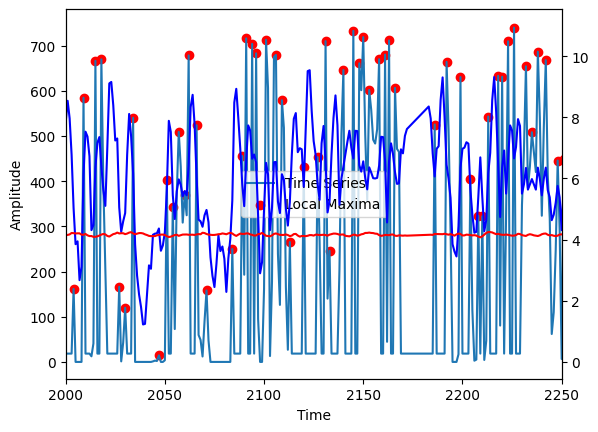

In [83]:
time = design_matrix['Bin']
fig, ax = plt.subplots()

# Plot the time series and local maxima
ax.plot(time, change_score, label='Time Series')
ax.scatter(time[intersect], change_score[intersect], color='red', label='Local Maxima')
ax.legend()
ax.set_xlabel('Time')
ax.set_ylabel('Amplitude')
ax.set_xlim([2000, 2250])

ax2 = ax.twinx()

ax2.plot(time, data_changepoints, color='blue')
ax2.plot(time, np.mean(shuffle_changepoints, axis=0), color='red')

### Grid serach

In [134]:
# Prepare grid
hs = [0.05, 0.1, 0.15]
sigmas = [0.1, 0.2, 0.3, 0.4]

results_data = {}
smoothed_data = {}
results_control ={}
summary_results = {}
    
for i, h in enumerate(hs):
    results_data[h] = {}
    smoothed_data[h] = {}
    results_control[h] = {}
    summary_results[h] = {}
    
    for isig, sigma in enumerate(sigmas):
        
        change_score, data_changepoints, shuffle_changepoints, intersect = peaks(use_data, h, sigma, shuffle_iters)
        
        """ Save results """
        results_data[h][sigma] = data_changepoints 
        smoothed_data[h][sigma] = change_score
        results_control[h][sigma] = shuffle_changepoints 
        summary_results[h][sigma] = len(intersect)

In [135]:

list_changepoints = []
keys = []
        
for ih, h in enumerate(hs):
    for isig, sigma in enumerate(sigmas):

        if len(list_changepoints) == 0:
            list_changepoints = [summary_results[h][sigma]]
            keys = [h, sigma]
        else:
            list_changepoints = np.vstack((list_changepoints, summary_results[h][sigma]))
            keys = np.vstack((keys, [h, sigma]))
                        
if len(list_changepoints) > 0:
    
    # Choose parameters
    flat_changepoints = list_changepoints.ravel()
    use_keys = keys[flat_changepoints==np.max(flat_changepoints)]

    # Calculate changepoints based on optimal parameters
    h = float(use_keys[0][0])
    sigma = float(use_keys[0][1])

change_score, data_changepoints, shuffle_changepoints, intersect = peaks(use_data, h, sigma, shuffle_iters)

In [145]:
change_score, data_changepoints, shuffle_changepoints, intersect = peaks(use_data, h, sigma, shuffle_iters)

In [144]:
sigma = 0.3
h = 0.1

## Visualize results

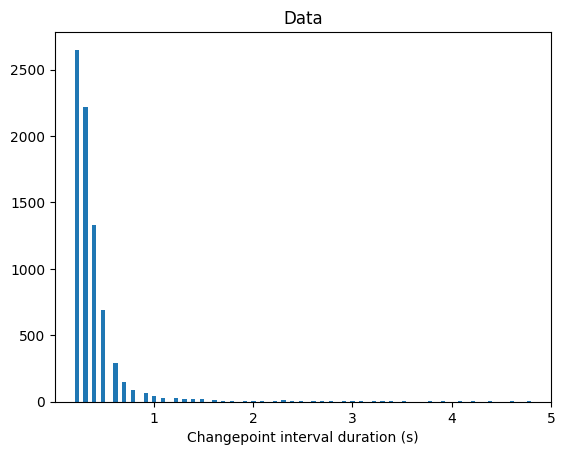

3.0


In [138]:
plt.hist(np.diff(intersect), bins=500)
plt.xlim([0, 50])
plt.xlabel('Changepoint interval duration (s)')
plt.xticks([10, 20, 30, 40, 50], [1, 2, 3, 4, 5])
plt.title('Data')
plt.show()

print(np.median(np.diff(intersect)))


(-0.5, 9.5)

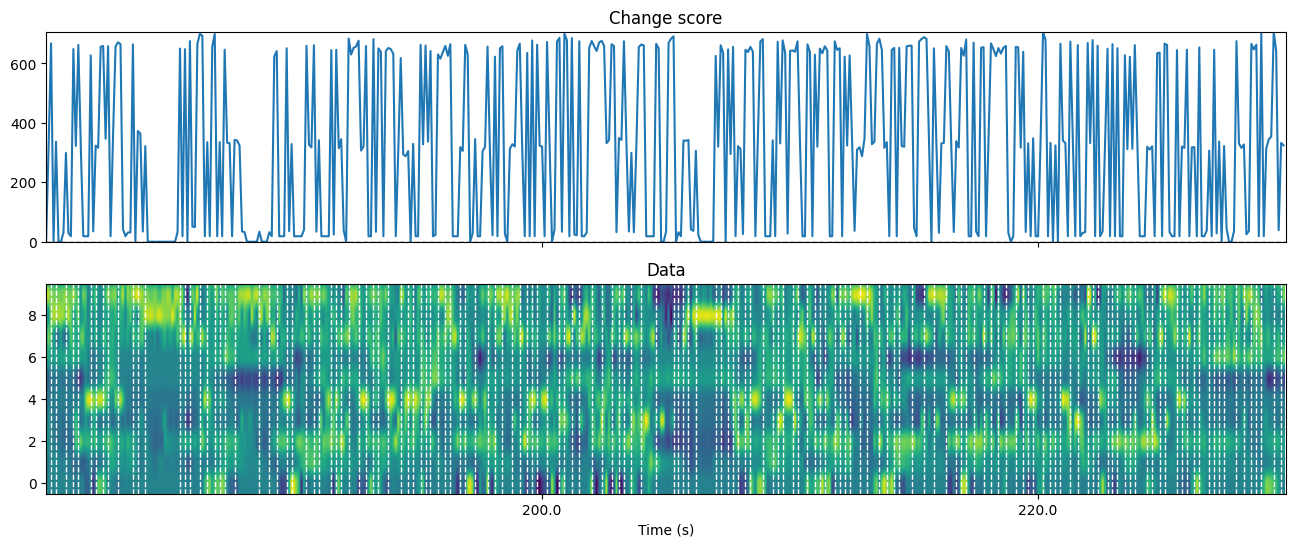

In [151]:
fig, ax = plt.subplots(nrows=2 , ncols=1, sharex=True, sharey=False, figsize=[16, 6])

interval = 500
init = 2000
end = init + interval

matrix = np.array(use_data[np.array(features)]).transpose()
vlines_data = intersect - init

# Plot the data matrix
ax[0].plot(change_score[init:end])
ax[0].hlines([h], 0, interval, color='black', linewidth=1, linestyles='--')
ax[0].set_title('Change score')
ax[0].set_ylim([np.min(change_score[init:end]), np.max(change_score[init:end])])

# Plot the data matrix
im1 = ax[1].imshow(matrix[:, init:end], aspect='auto')
ax[1].vlines(vlines_data, -0.5, 9.5, color='white', linewidth=1, linestyles='--')
ax[1].set_title('Data')
labels = [init/10 , init/10+20, init/10+40]
ax[1].set_xticks([200, 400, 600], labels)
ax[1].set_xlabel('Time (s)')
ax[1].set_xlim([0, interval])
ax[1].set_ylim([-0.5, 9.5])

#plt.tight_layout()


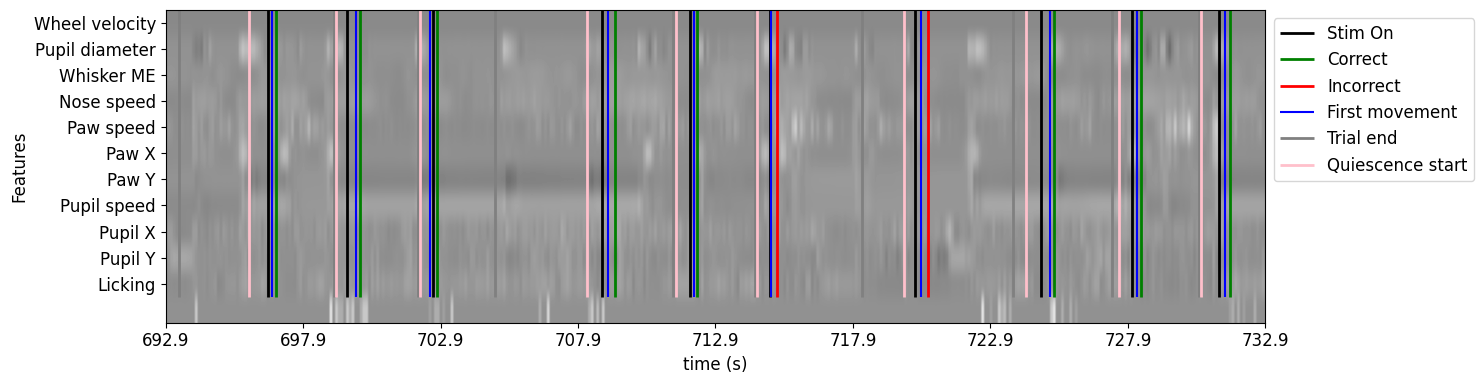

In [31]:
init = 6000
end = init + 400
plt.rc('font', size=12)

fig, axs = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(15, 4))

cmap = plt.cm.gray
use_data = scaler.fit_transform(X)
im1 = axs.imshow(use_data.transpose(), aspect='auto', cmap=cmap)  # [:, init:end]
bin_init = design_matrix['Bin'][0]


axs.vlines(np.array(session_trials['goCueTrigger_times'] * 10 - bin_init),-0.5, 10.5, label='Stim On', color='Black', linewidth=2)
axs.vlines(np.array(session_trials.loc[session_trials['feedbackType']==1, 'feedback_times'] * 10 - bin_init), -0.5, 10.5, label='Correct', color='Green', linewidth=2)
axs.vlines(np.array(session_trials.loc[session_trials['feedbackType']==-1, 'feedback_times'] * 10 - bin_init), -0.5, 10.5, label='Incorrect', color='Red', linewidth=2)
axs.vlines(np.array(session_trials['firstMovement_times'] * 10 - bin_init), -0.5, 10.5, label='First movement', color='Blue')
axs.vlines(np.array(session_trials['intervals_0'] * 10 - bin_init), -0.5, 10.5, label='Trial end', color='Grey', linewidth=2)
axs.vlines(np.array((session_trials['goCueTrigger_times'] - session_trials['quiescencePeriod']) * 10 - bin_init), -0.5, 10.5, label='Quiescence start', color='Pink', linewidth=2)
#axs.set_ylim(0, 1)

axs.set_ylabel("Features")
axs.set_xlabel("time (s)")
axs.set_xlim(init, end)
axs.set_xticks(np.arange(init, end+50, 50),np.arange((init+bin_init)/10, (end+bin_init)/10+5, 5))
feature_names = ['Wheel velocity', 'Pupil diameter', 'Whisker ME', 'Nose speed', 'Paw speed', 'Paw X', 'Paw Y', 'Pupil speed', 'Pupil X', 'Pupil Y', 'Licking']
axs.set_yticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], feature_names)
axs.legend(loc='upper left', bbox_to_anchor=(1, 1))
cbar1 = fig.colorbar(im1, ax=ax)

plt.tight_layout()
plt.show()

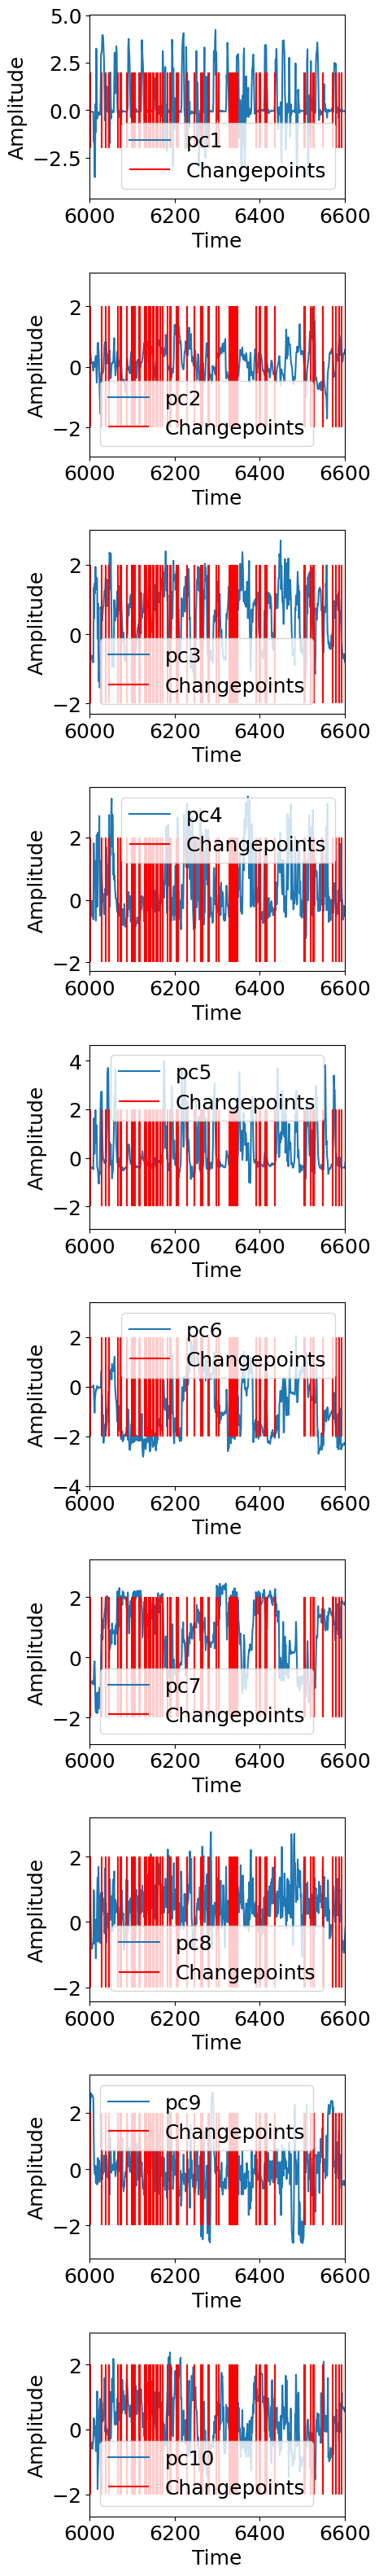

In [296]:
derivative = augmented_data.copy()
pcs = augmented_data.keys()[1:]

min = 6000
max = min + 600

fig, ax = plt.subplots(nrows=len(pcs) , ncols=1, sharex=False, sharey=False, figsize=[5, 32])

for i, pc in enumerate(pcs):
    
    #time = augmented_data['Bin']
    time = np.arange(0, len(augmented_data['Bin']), 1)
    # Plot the time series and local maxima
    ax[i].plot(time, augmented_data[pc], label=pc)
    ax[i].vlines(data_changepoints, -2, 2, color='red', label='Changepoints')
    ax[i].legend()
    ax[i].set_xlabel('Time')
    ax[i].set_ylabel('Amplitude')
    ax[i].set_xlim([min, max])
    
plt.tight_layout()
